Experiment working with anonymized API log data.

In [11]:
import pandas as pd
import seaborn as sns
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.figure()

In [3]:
api_logs = pd.read_csv('api_logs.csv', index_col=0, parse_dates=[0])
# Take a look at the columns available
api_logs.columns

Index(['Method', 'Country', 'State', 'City', 'Status', 'Reason Denied',
       'Response Time', 'Content Type', 'Accept Encoding', 'User Agent',
       'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')

In [4]:
print(api_logs.index)

DatetimeIndex(['2017-04-25 11:43:48', '2017-04-25 11:43:48',
               '2017-04-25 11:43:48', '2017-04-25 11:45:34',
               '2017-04-25 11:47:39', '2017-04-25 11:46:01',
               '2017-04-25 11:47:20', '2017-04-25 11:46:10',
               '2017-04-25 11:46:17', '2017-04-25 11:44:46',
               ...
               '2017-05-31 07:50:32', '2017-05-31 07:52:05',
               '2017-05-31 08:23:18', '2017-05-31 09:55:25',
               '2017-05-31 09:53:51', '2017-05-31 09:55:31',
               '2017-05-31 10:05:42', '2017-05-31 10:05:50',
               '2017-05-31 10:05:50', '2017-05-31 10:09:36'],
              dtype='datetime64[ns]', name='Time', length=2912, freq=None)


In [5]:
def is_success_function(row):
    """
    Check if row (request) was successful
    Successful means a response with 2xx status
    
    return True if successful False otherwise
    """
    success = (row['Status'] >= 200 and row['Status'] < 300)
    
    if success:
        return 'Success'
    else:
        return 'Failure'
    
# Add 'Success' column to API Logs
# Success is determined by status code, where any status in the 200s is considered successful
api_logs['Outcome'] = api_logs.apply(is_success_function , axis='columns')
api_logs.head()

,Method,Country,State,City,Status,Reason Denied,Response Time,Content Type,Accept Encoding,User Agent,Unnamed: 11,Unnamed: 12,Outcome
Time,,,,,,,,,,,,,
2017-04-25 11:43:48,GET,RU,38,Krasnodar,200,NaN,305,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success
2017-04-25 11:43:48,GET,RU,38,Krasnodar,200,NaN,383,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success
2017-04-25 11:43:48,GET,RU,38,Krasnodar,200,NaN,25,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success
2017-04-25 11:45:34,GET,RU,38,Krasnodar,200,NaN,67,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success
2017-04-25 11:47:39,GET,RU,38,Krasnodar,200,NaN,45,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success


# Analysis
Get a feel for the data.

In [6]:
# Check the distribution of statuses in the data
api_logs['Status'].value_counts().plot('bar', title='Response code counts')

In [7]:
# Compare number of successful versus unsuccessful requests
success_versus_failure = api_logs.groupby('Outcome').size().plot('bar', title='Successful versus unsuccessful requests')

In [8]:
api_logs.groupby([api_logs.index.date, 'Outcome']).size()

            Outcome
2017-04-22  Success      7
2017-04-24  Failure     32
            Success     59
2017-04-25  Failure     23
            Success     91
2017-04-26  Failure      1
            Success     59
2017-04-27  Failure      3
            Success      1
2017-04-28  Failure      1
            Success      2
2017-04-29  Success      3
2017-05-03  Failure     38
2017-05-04  Failure      6
            Success    727
2017-05-05  Success      1
2017-05-08  Failure      3
            Success      6
2017-05-09  Failure      2
            Success      2
2017-05-10  Success      1
2017-05-11  Failure      6
            Success     32
2017-05-12  Success     62
2017-05-15  Failure      2
            Success     47
2017-05-16  Success     23
2017-05-17  Success     29
2017-05-18  Failure      1
            Success     65
                      ... 
2017-07-20  Success      1
2017-07-23  Success      1
2017-07-24  Success      1
2017-07-26  Success      1
2017-07-31  Success      1
2017-08-

In [9]:
# Group (count) success and failure messages by date, making sure success and failure are in own columns
success_and_failure_over_time = api_logs.groupby([api_logs.index.date, 'Outcome']).size().unstack()
success_and_failure_over_time

Outcome,Failure,Success
2017-04-22,NaN,7.0
2017-04-24,32.0,59.0
2017-04-25,23.0,91.0
2017-04-26,1.0,59.0
2017-04-27,3.0,1.0
2017-04-28,1.0,2.0
2017-04-29,NaN,3.0
2017-05-03,38.0,NaN
2017-05-04,6.0,727.0
2017-05-05,NaN,1.0


<IPython.core.display.Javascript object>


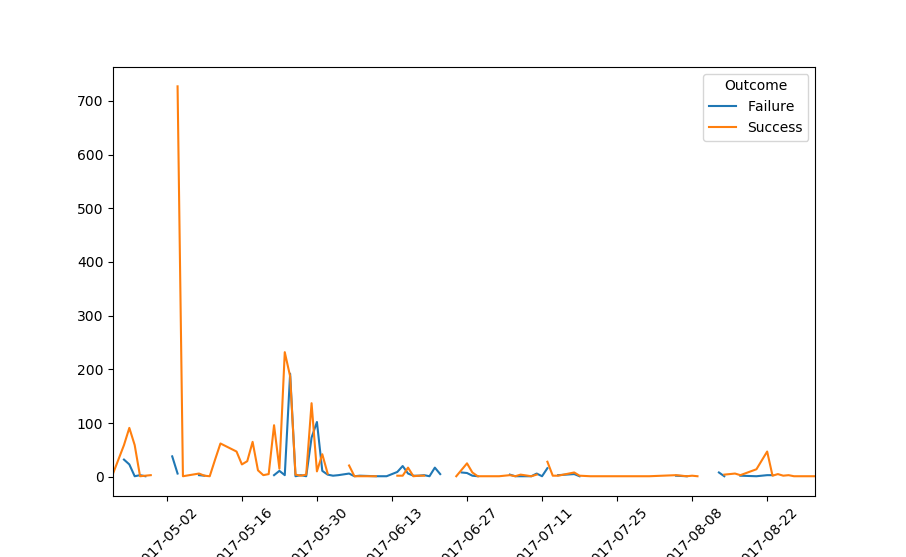

In [10]:
# Plot success and failure countes over time
success_and_failure_chart = success_and_failure_over_time.plot(rot=45)